# Stochastic upwind/downwind turning model

## Investigating the importance of odor frequency and duration

## Q-learning algorithm
Q-learning updates a state-action value function, $Q(a, s)$, which quantifies the value of taking action $a$ when in state $s$. This function is updated in time using the Q-learning algorithm. At each timestep, the navigator takes an action $A$ to go from state $S$ to state $S'$, using whatever policy (greedy, $\epsilon$-greedy, etc.), where it receives a reward $R$. Then $Q(A, S)$ is updated using a *greedy* update rule (hence *off-policy*):

$\begin{align}
 Q(A, S) \leftarrow Q(A, S) + \alpha[R + \gamma \max_a Q(a, S')  - Q(A, S)]
\end{align}$

Here, $\alpha < 1$ and $\gamma < 1$ are learning and reward discount rate -- both hyperparameters in the simulation.

## Model states, actions, and rewards

The *upwind-downwind-centerline* model explored in this notebook is defined by its states and actions.

### State space: $\{s\}$

Following results found recently for navigation of odor plumes by fruit flies, we assume that navigators rely on both the frequency and duration of odor hits. An odor hit is the time at which the signal surpassses a given threshold. Running average of hit frequency, $W_{freq}$, is found by convolving the binary time series of odor hit times $w(t)$ with an exponential kernel ($\tau = 2$ seconds):

$W_{freq} = \int^t_{-\infty} e^{-(t-t')/\tau} w(t')dt'$

While the running average of hit duration is found by convolving the binary time series of odor exposure $d(t)$, which is 1 when the odor is above a threshold and 0 below, with an exponential kernel ($\tau = 2$ seconds):

$W_{dur} = \int^t_{-\infty} e^{-(t-t')/\tau} d(t')dt'$

We discretize the state space by odor hit frequency with partitions $\{a_i\}$ and odor hit duration with partitions $\{b_m\}$

$S_{im}$: $a_i < W_{freq} < a_{i+1}$ and $b_m < W_{dur} < b_{m+1}$ 

### Action space: $\{a\}$
We assume that there are 2 actions:

$A_1$: Make a turn **upwind** with random angle $\sim \mathcal N(30, 10)$, following recent results in fruit fly navigation

$A_2$: Make a turn **downwind** with random angle $\sim \mathcal N(30, 10)$.

At each timestep, the actions are stochastic in the sense that there is a $p_{turn} < 1$ probability to turn, and a $1 - p_{turn}$ probability to make a small jitter, which is a turn with angle much less than 30 in a random direction.

### Reward space: $\{r\}$
We assume the rewards are 1 if the navigator is experiencing a plume hit (odor signal is above threshold) and 0 otherwise. 

In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append('src')
from utils import gen_plot
from models import *

## Run the RL simulation

### Instantiate model class
Define number of parallel agents and how many steps in episode

In [2]:
a = stochastic_turning_dur_freq()
a.x0_min = 500
a.xo_max = 1000
a.max_x = 1000
a.y0_spread = 200
a.num_walkers = 20000
a.num_steps = 5000
a.def_actions()

### Set the frequency partitions defining the states

In [3]:
freq_bins = [-1, 0.01, 0.5, 2, 4, 100]
dur_bins = [-1, 0.02, 0.2, 0.4, 0.6, 100]
a.def_states(freq_bins=freq_bins, dur_bins=dur_bins)

### Run

In [4]:
xs, ys, Q, Q_terminal, path_lengths = a.run()

100.0%

### Save

In [ ]:
# data_to_save = dict()
# data_to_save['xs'] = xs
# data_to_save['ys'] = ys
# data_to_save['path_lengths'] = path_lengths
# data_to_save['Q_terminal'] = Q_terminal
# file = 'res_data.pkl'
# import pickle
# with open(file, 'wb') as f:
#     pickle.dump(data_to_save, f)

### Plot the Q-function for each state

Note that as odor hit frequency increases, the optimal action goes from being random to being more directed upwind.

No handles with labels found to put in legend.


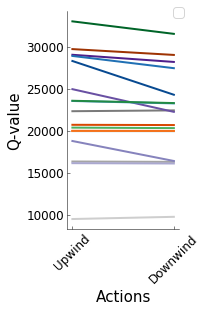

In [40]:
num_freqs = len(a.freq_bins) - 1
num_durs = len(a.dur_bins) - 1
fig, ax = gen_plot(2, 4)
cmaps = [plt.cm.Greys, plt.cm.Purples, plt.cm.Blues, 
         plt.cm.Greens, plt.cm.Oranges, plt.cm.Reds]
colors = np.linspace(0.3, 0.9, num_freqs)
for iS in range(num_durs):
    for iT in range(num_freqs):
        idx = iS*num_freqs + iT
        plt.plot(Q_terminal[idx], color=cmaps[iS](colors[iT]), lw=2)

plt.xlabel('Actions', fontsize=15)
plt.ylabel('Q-value', fontsize=15)
plt.xticks(range(a._num_actions), fontsize=12)
plt.yticks(fontsize=12)
ax.set_xticklabels(['Upwind', 'Downwind'], rotation=45)
plt.legend(bbox_to_anchor=(1.1, 1.05), fontsize=13)
plt.show()

### Plot trajectories of virtual navigators during learning
Blue is beginning; yellow is end. Odor source is at middle left (see plume snapshot above)

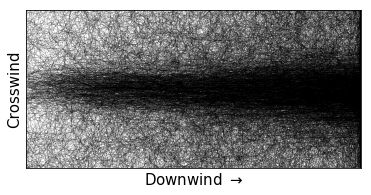

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
for iW in range(a.num_walkers)[::50]:
    plt.plot(xs[:path_lengths[iW], iW], 
                ys[:path_lengths[iW], iW], color='k',
                lw=0.1)

ax.set_aspect('equal')
plt.xticks([])
plt.yticks([])
plt.xlabel(r'Downwind $\rightarrow$', fontsize=15)
plt.ylabel('Crosswind', fontsize=15)
ax.set_xlim(150, 1000)
ax.set_ylim(450 - 200, 450 + 200)
plt.show()

### Plot the softmax action selection of Q-function with temperature $T = 125$
Softmax derives a probability of each action from the learned $Q$, as such:

\begin{align}
p_{T}(action|state) = \frac{e^{Q(action|states)/T}}{\sum_{actions}e^{Q(action|states)/T}}
\end{align}

Note that as odor hit frequency increases, the optimal action goes from being slightly downwind-preferred to being strongly upwind.

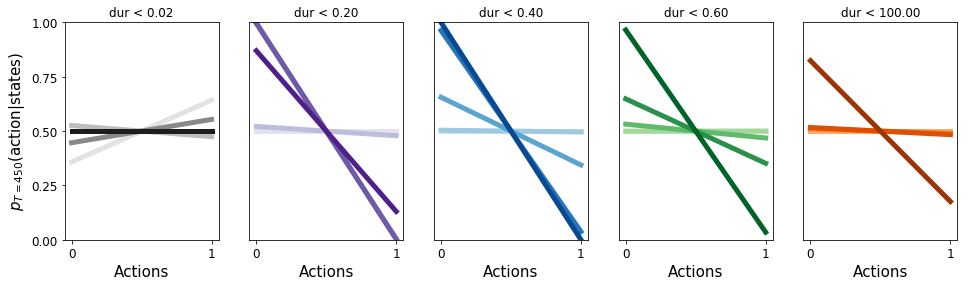

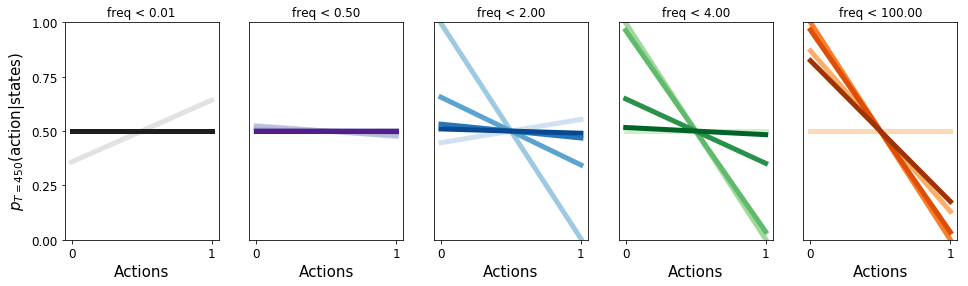

In [311]:
temp = 450
Q_norm = (np.exp(Q_terminal.T/temp)/np.sum(np.exp(Q_terminal/temp), axis=-1)).T

num_freqs = len(a.freq_bins) - 1
num_durs = len(a.dur_bins) - 1
fig, ax = gen_plot(16, 4)
cmaps = [plt.cm.Greys, plt.cm.Purples, plt.cm.Blues, 
         plt.cm.Greens, plt.cm.Oranges, plt.cm.Reds]
colors = np.linspace(0.2, 0.9, num_freqs)
for iS in range(num_durs):
    plt.subplot(1, num_durs, iS + 1)
    for iT in range(num_freqs):
        idx = iS*num_freqs + iT
        plt.plot(Q_norm[idx], color=cmaps[iS](colors[iT]), lw=5)
    plt.xlabel('Actions', fontsize=15)
    plt.xticks(range(a._num_actions), fontsize=12)
    if iS == 0:
        plt.ylabel(r'$p_{T=%s}($action|states)' % temp, fontsize=15)
        plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=12)
    else:
        plt.yticks([])
    ax.set_xticklabels(['Upwind', 'Downwind'], rotation=45)
    plt.ylim(0, 1)
    plt.title('dur < %.2f' % a.dur_bins[1:][iS])
plt.show()

fig, ax = gen_plot(16, 4)
cmaps = [plt.cm.Greys, plt.cm.Purples, plt.cm.Blues, 
         plt.cm.Greens, plt.cm.Oranges, plt.cm.Reds,
         plt.cm.Reds]
colors = np.linspace(0.2, 0.9, num_durs)
for iS in range(num_freqs):
    plt.subplot(1, num_freqs, iS + 1)
    for iT in range(num_durs):
        idx = iT*num_freqs + iS
        plt.plot(Q_norm[idx], color=cmaps[iS](colors[iT]), lw=5)
    plt.xlabel('Actions', fontsize=15)
    plt.xticks(range(a._num_actions), fontsize=12)
    if iS == 0:
        plt.ylabel(r'$p_{T=%s}($action|states)' % temp, fontsize=15)
        plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=12)
    else:
        plt.yticks([])
    ax.set_xticklabels(['Upwind', 'Downwind'], rotation=45)
    plt.ylim(0, 1)
    plt.title('freq < %.2f' % a.freq_bins[1:][iS])
plt.show()

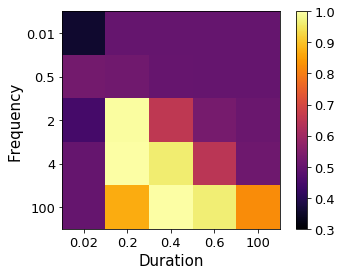

In [335]:
Q_norm_reshape = np.reshape(Q_norm[:, 0], (num_durs, num_freqs), order='C')
plt.imshow(Q_norm_reshape.T, vmax=1, vmin=0.3, cmap=plt.cm.inferno)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=13) 

plt.xticks(range(num_durs), a.dur_bins[1:], fontsize=13)
plt.yticks(range(num_freqs), a.freq_bins[1:], fontsize=13)
plt.xlabel('Duration', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

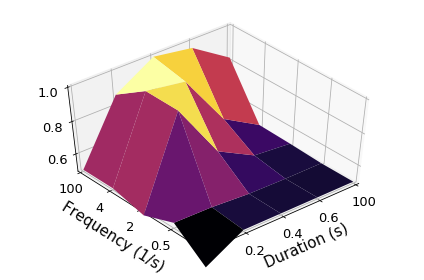

In [386]:
fig = plt.figure(figsize=(6, 4))
ax = plt.axes(projection='3d')
X, Y  = np.meshgrid(range(num_freqs), range(num_durs))
Z = Q_norm_reshape

ax.view_init(50, 230)
ax.plot_surface(Y, X, Z, rstride=1, cstride=1,
                cmap='inferno', edgecolor='none')
plt.xlim(0, num_durs - 1)
plt.ylim(0, num_freqs - 1)
ax.set_zlim(0.5, 1)
ax.set_zticks([0.6, 0.8, 1.])
ax.set_zticklabels([0.6, 0.8, 1.], fontsize=13)
plt.xticks(range(0, num_durs), a.dur_bins[1:], fontsize=13)
plt.yticks(range(0, num_freqs), a.freq_bins[1:], fontsize=13)
xlabels = ['']
for dur_bin in a.dur_bins[2:]:
    xlabels.append(dur_bin)
ylabels = ['']
for freq_bin in a.freq_bins[2:]:
    ylabels.append(freq_bin)
ax.set_xticklabels(xlabels, fontsize=13)
ax.set_yticklabels(ylabels, fontsize=13)
plt.xlabel('Duration (s)', fontsize=15, labelpad=10)
plt.ylabel('Frequency (1/s)', fontsize=15, labelpad=10)
ax.dist = 11
plt.tight_layout()
plt.savefig('fig.png', dpi=300)
plt.show()

### Simulate navigators using learned softmax Q-policy

Navigators choose actions that optimize $p_T(actions|state)$, derived from the softmax of $Q$. This policy is $\epsilon$-greedy, whereby random actions are chosen with probability $\epsilon = 5\%$

In [28]:
a.x0_min = 500
a.xo_max = 1000
a.max_x = 1000
a.y0_spread = 200
a.num_walkers = 100
xs, ys, path_lengths = a.run_optimal_action(Q_terminal, temp=125)

100.0%

### Plot the navigator trajectories from softmax Q-policy
Note that optimal policy outside of the plume (odor hit frequency is low) is to take random actions with some preference for moving toward the centerline. Once in a region of high hits, the optimal policy is to go upwind, so the navigators move toward the source once in the center of the plume

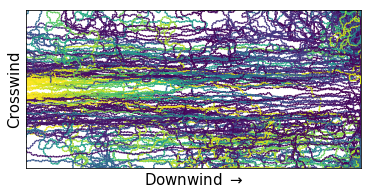

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
for iW in range(a.num_walkers):
    colors = plt.cm.viridis(np.linspace(0, 1, path_lengths[iW]))
    plt.scatter(xs[:path_lengths[iW], iW], 
                ys[:path_lengths[iW], iW], 
                c=colors, s=.5)

ax.set_aspect('equal')
plt.xticks([])
plt.yticks([])
plt.xlabel(r'Downwind $\rightarrow$', fontsize=15)
plt.ylabel('Crosswind', fontsize=15)
ax.set_xlim(150, 1000)
ax.set_ylim(450 - 200, 450 + 200)
plt.show()